In [1]:
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
from tqdm import tqdm
tqdm.pandas()
from catboost import CatBoostClassifier

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, RepeatedStratifiedKFold
from sklearn import metrics
from lightgbm import LGBMClassifier
from IPython.display import FileLink

In [2]:
train_file = 'train.csv'
test_file = 'test.csv'
filename = 'result.csv'

In [3]:
df, tdf = pd.read_csv(train_file), pd.read_csv(test_file)

In [4]:
df.columns

Index(['case_id', 'Hospital_code', 'Hospital_type_code', 'City_Code_Hospital',
       'Hospital_region_code', 'Available Extra Rooms in Hospital',
       'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade',
       'patientid', 'City_Code_Patient', 'Type of Admission',
       'Severity of Illness', 'Visitors with Patient', 'Age',
       'Admission_Deposit', 'Stay'],
      dtype='object')

In [5]:
for col in df.columns:
    print(df[col].value_counts(normalize=True, dropna=False, ascending=True))
    print(df[col].nunique())
    print("=========++++++++")


2049      0.000003
19875     0.000003
17826     0.000003
23969     0.000003
21920     0.000003
            ...   
19036     0.000003
29275     0.000003
31322     0.000003
107105    0.000003
2047      0.000003
Name: case_id, Length: 318438, dtype: float64
318438
=========++++++++
4     0.003894
7     0.004101
20    0.004412
18    0.011399
8     0.011503
16    0.011528
31    0.012458
22    0.013431
30    0.015708
2     0.016022
13    0.016443
1     0.016484
5     0.016521
17    0.017275
3     0.022347
24    0.025098
21    0.025594
15    0.029070
10    0.029629
25    0.030882
32    0.033611
12    0.035476
29    0.035520
9     0.036145
27    0.044731
28    0.053816
14    0.054416
11    0.054416
6     0.064141
19    0.066635
23    0.083426
26    0.103870
Name: Hospital_code, dtype: float64
32
=========++++++++
g    0.013431
f    0.033611
d    0.064028
e    0.077786
c    0.144229
b    0.216513
a    0.450402
Name: Hospital_type_code, dtype: float64
7
=========++++++++
13    0.011399
10    0.0

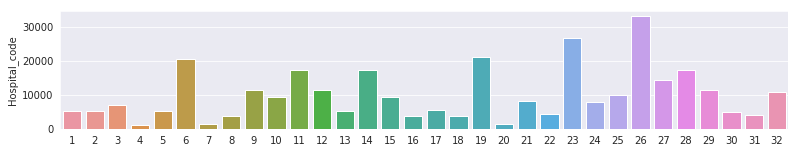

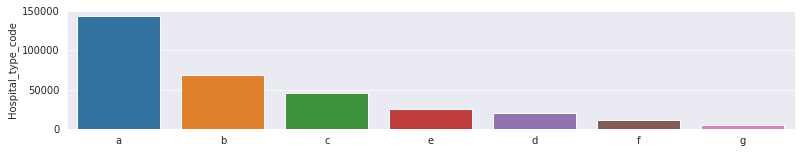

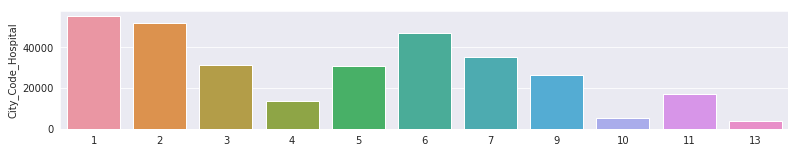

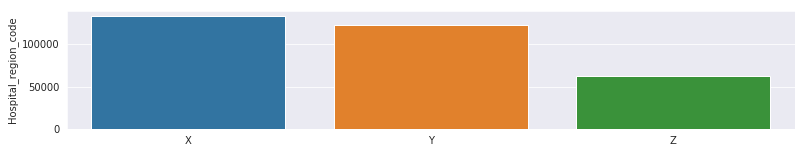

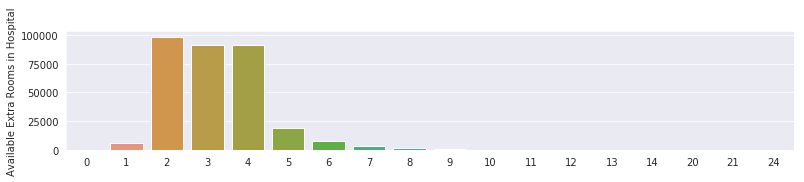

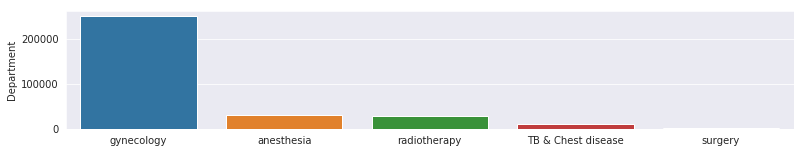

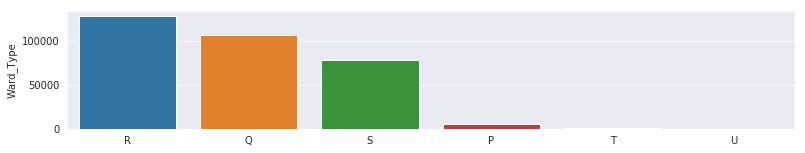

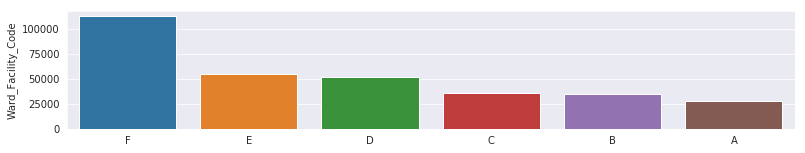

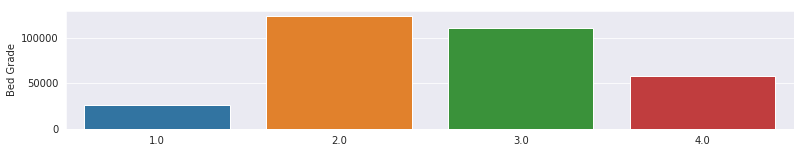

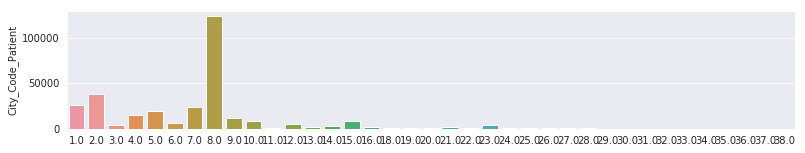

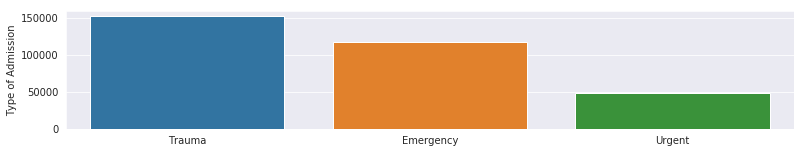

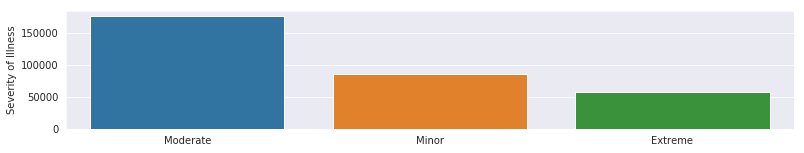

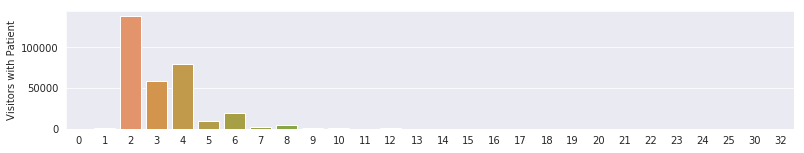

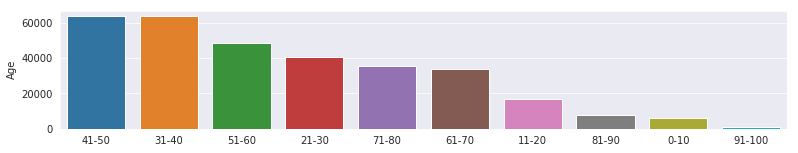

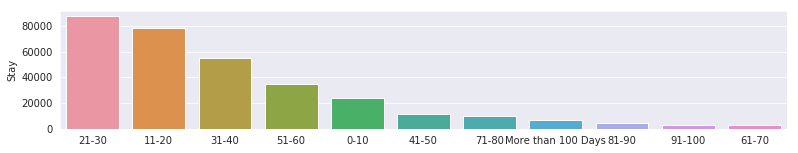

In [6]:
i = 1
for column in df.columns[~(df.columns.isin(['case_id', 'patientid', 'Admission_Deposit']))].tolist():
    plt.figure(figsize = (60, 10))
    plt.subplot(4, 4, i)
    sns.barplot(x = df[column].value_counts().index, y = df[column].value_counts())
    i += 1
    plt.show()

In [7]:
reg_cols = ['Admission_Deposit']
useless_cols = ['case_id', ]
cat_cols = ['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital', 'Hospital_region_code', 'Available Extra Rooms in Hospital','Department', 
            'Ward_Type', 'Ward_Facility_Code', 'Bed Grade', 'patientid' , 'City_Code_Patient', 'Type of Admission' , 'Severity of Illness', 
            'Visitors with Patient', 'Age', 'Stay']
len(reg_cols), len(useless_cols), len(cat_cols), len(df.columns)

(1, 1, 16, 18)

In [8]:
target_encoder = LabelEncoder()
encoder_cols = {
    'Hospital_code':1,
    'Hospital_type_code':1,
    'City_Code_Hospital':1,
    'Hospital_region_code':1,
    'Available Extra Rooms in Hospital':1,
    'Department':1,
    'Ward_Type':1,
    'Ward_Facility_Code':1,
    'Bed Grade':1,
    'Type of Admission': 1,
    'Severity of Illness': 1,
    
    'Age': 1
}

def label_encoding(dframe, col, test=False):
    if col not in dframe.columns: return
    if col == 'Stay':
        if not test:
            dframe[col] = target_encoder.fit_transform(dframe[col])
        else:
            dframe[col] = target_encoder.transform(dframe[col])
    elif col in encoder_cols:
        if not test:
            encoder_cols[col] = LabelEncoder()
            dframe[col] = encoder_cols[col].fit_transform(dframe[col])
        else:
            dframe[col] = encoder_cols[col].transform(dframe[col])
    else:    
        label_encoder = LabelEncoder()
        dframe[col] = label_encoder.fit_transform(dframe[col])

df['Bed Grade'].fillna(-1, inplace=True)
tdf['Bed Grade'].fillna(-1, inplace=True)

df['City_Code_Patient'].fillna(0, inplace=True)
tdf['City_Code_Patient'].fillna(0, inplace=True)

df.fillna('NaN', inplace=True)
tdf.fillna('NaN', inplace=True)
for col in tqdm(cat_cols):
    label_encoding(df, col)
    label_encoding(tdf, col, True)
    

100%|██████████| 16/16 [00:00<00:00, 24.07it/s]


In [9]:
def create_feature_for_patient_id(dframe, patientid="patientid", caseid="case_id"): 
    cnt = {} 
    for index, row in tqdm(dframe.iterrows()): 
        p = row[patientid]
        if p in cnt: 
            cnt[p] += 1 
        else: 
            cnt[p] = 1 
    current_cnt = {} 
    s = [] 
    for index, row in tqdm(dframe.iterrows()): 
        p = row[patientid]
        if p in current_cnt: current_cnt[p] += 1 
        else: current_cnt[p] = 1
        s.append(current_cnt[p] / cnt[p]) 
    return pd.Series(s)

In [10]:
df['patient_city_code_f'] = create_feature_for_patient_id(df, patientid='City_Code_Patient')
tdf['patient_city_code_f'] = create_feature_for_patient_id(tdf, patientid='City_Code_Patient')

318438it [00:21, 15060.26it/s]
318438it [00:21, 15039.30it/s]
137057it [00:08, 15247.69it/s]
137057it [00:09, 15014.33it/s]


In [11]:
df['patientid_f'] = create_feature_for_patient_id(df)
tdf['patientid_f'] = create_feature_for_patient_id(tdf)

318438it [00:21, 15134.42it/s]
318438it [00:21, 14727.71it/s]
137057it [00:09, 14361.17it/s]
137057it [00:09, 14196.76it/s]


In [12]:
for col in df.columns:
    print(df[col].value_counts(normalize=True, dropna=False, ascending=True))
    print(df[col].nunique())
    print("=========++++++++")

2049      0.000003
19875     0.000003
17826     0.000003
23969     0.000003
21920     0.000003
            ...   
19036     0.000003
29275     0.000003
31322     0.000003
107105    0.000003
2047      0.000003
Name: case_id, Length: 318438, dtype: float64
318438
=========++++++++
3     0.003894
6     0.004101
19    0.004412
17    0.011399
7     0.011503
15    0.011528
30    0.012458
21    0.013431
29    0.015708
1     0.016022
12    0.016443
0     0.016484
4     0.016521
16    0.017275
2     0.022347
23    0.025098
20    0.025594
14    0.029070
9     0.029629
24    0.030882
31    0.033611
11    0.035476
28    0.035520
8     0.036145
26    0.044731
27    0.053816
13    0.054416
10    0.054416
5     0.064141
18    0.066635
22    0.083426
25    0.103870
Name: Hospital_code, dtype: float64
32
=========++++++++
6    0.013431
5    0.033611
3    0.064028
4    0.077786
2    0.144229
1    0.216513
0    0.450402
Name: Hospital_type_code, dtype: float64
7
=========++++++++
10    0.011399
8     0.0

In [13]:
for col in df.columns:
    if col in cat_cols and col in tdf.columns and tdf[col].nunique() == tdf[col].nunique():
        print(col)
        

Hospital_code
Hospital_type_code
City_Code_Hospital
Hospital_region_code
Available Extra Rooms in Hospital
Department
Ward_Type
Ward_Facility_Code
Bed Grade
patientid
City_Code_Patient
Type of Admission
Severity of Illness
Visitors with Patient
Age


In [14]:
ss = StandardScaler()
for col in tqdm(df.columns[~(df.columns.isin(['case_id', 'Stay']))].tolist()):
    df[[col]] = ss.fit_transform(df[[col]])
    tdf[[col]] = ss.fit_transform(tdf[[col]])

100%|██████████| 18/18 [00:02<00:00,  7.21it/s]


In [15]:
X = df[df.columns[~(df.columns.isin(['case_id', 'Stay']))].tolist()].values
y = df['Stay'].values

In [16]:
grid = {'learning_rate': [0.1],
        'max_depth': [6, 8, 10],
        'n_estimators': [500]}

model = CatBoostClassifier(random_state = 22, # task_type="GPU", devices='0:1', 
                           max_depth=8, n_estimators= 500, learning_rate=0.1, verbose=False)

model.fit(X, y)


In [17]:
# grid_search_result = model.grid_search(grid, X=X, y=y, cv=6, shuffle=True, stratified=True, verbose=True, plot=True, refit=True)

In [18]:
predictions = model.predict(tdf[tdf.columns[~(tdf.columns.isin(['case_id']))].tolist()].values)
result = pd.DataFrame({'case_id': tdf['case_id'], 'Stay': predictions.ravel()})

In [19]:
result['Stay'] = target_encoder.inverse_transform(result['Stay'])

In [20]:
result.to_csv(filename, index=False)
FileLink(filename)

/Users/ashutosh.tiwari1/personal/AnalyticsVidhya_JANATAHACK/result.csv

In [21]:
# grid_search_result['params']

In [22]:
for i, j in zip(df[df.columns[~(df.columns.isin(['case_id', 'Stay']))].tolist()].columns, model.feature_importances_):
    print(i, j)

Hospital_code 5.112912370270491
Hospital_type_code 2.9364130365116172
City_Code_Hospital 4.248094019866339
Hospital_region_code 1.5876203484127487
Available Extra Rooms in Hospital 4.329465955185728
Department 2.065176135695708
Ward_Type 10.055718903027257
Ward_Facility_Code 2.711057137469297
Bed Grade 4.743582366922878
patientid 4.552436837964238
City_Code_Patient 6.339924204593967
Type of Admission 5.034268164631842
Severity of Illness 3.4217315860657878
Visitors with Patient 21.42052577778124
Age 4.785633888867217
Admission_Deposit 6.4407515575211365
patient_city_code_f 5.703724214888973
patientid_f 4.5109634943235415
